In [243]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import ta
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,
    confusion_matrix, classification_report, PrecisionRecallDisplay, roc_curve, precision_recall_curve # <-- Убедитесь, что эта строка здесь
)
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE 

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # Для XGBoost
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [245]:
ticker = 'BTC-USD'
start_date = '2015-07-10'
end_date = pd.to_datetime('today').strftime('2025-11-10')


In [247]:
print(f"Загрузка данных для {ticker} с {start_date} по {end_date}...")
df = yf.download(ticker, start=start_date, end=end_date)
print("Данные загружены.")
df.head()


C:\Users\User\AppData\Local\Temp\ipykernel_10668\1942105568.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Загрузка данных для BTC-USD с 2015-07-10 по 2025-11-10...
Данные загружены.


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-07-10,284.894012,294.591003,268.802002,269.156006,100390000
2015-07-11,293.114990,298.506012,283.529999,284.880005,41109900
2015-07-12,310.867004,314.394012,292.505005,293.140015,56405000
2015-07-13,292.053986,310.947998,281.010986,310.826996,62053900
2015-07-14,287.463989,296.147003,286.638000,292.033997,28727200


In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3776 entries, 2015-07-10 to 2025-11-09
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   3776 non-null   float64
 1   (High, BTC-USD)    3776 non-null   float64
 2   (Low, BTC-USD)     3776 non-null   float64
 3   (Open, BTC-USD)    3776 non-null   float64
 4   (Volume, BTC-USD)  3776 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 177.0 KB


In [251]:
df.isnull().sum()

Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64

In [253]:
print(df.head())

Price            Close        High         Low        Open     Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD    BTC-USD
Date                                                                 
2015-07-10  284.894012  294.591003  268.802002  269.156006  100390000
2015-07-11  293.114990  298.506012  283.529999  284.880005   41109900
2015-07-12  310.867004  314.394012  292.505005  293.140015   56405000
2015-07-13  292.053986  310.947998  281.010986  310.826996   62053900
2015-07-14  287.463989  296.147003  286.638000  292.033997   28727200


In [255]:
price_col = 'Close'

In [258]:
df['Log_Return'] = np.log(df[price_col] / df[price_col].shift(1))

In [260]:
df['Log_Return'].dropna()

Date
2015-07-11    0.028448
2015-07-12    0.058800
2015-07-13   -0.062427
2015-07-14   -0.015841
2015-07-15   -0.005704
                ...   
2025-11-05    0.022400
2025-11-06   -0.025251
2025-11-07    0.020239
2025-11-08   -0.010603
2025-11-09    0.023552
Name: Log_Return, Length: 3775, dtype: float64

In [262]:
df['Log_Return'].max()

0.22511895434132784

In [264]:
# усредняем изменчивость цены(волатильность) за 21 день, то есть просто сглаживаем
window_size_vol = 21

Волатильность — это мера изменчивости цены. под волатильностью обычно понимают стандартное отклонение логарифмических доходностей за год.
Если измерять разброс логарифмических доходностей, получаем оценку того, насколько активно меняется цена.

In [267]:
df['Rolling_Volatility'] = df['Log_Return'].shift(1).rolling(window=window_size_vol).std() * np.sqrt(365)


In [269]:
print(df['Rolling_Volatility'].isnull().sum())

22


In [271]:
df.dropna(inplace=True)

In [273]:
df['Rolling_Volatility'].mean()

0.6026191442701238

Буду брать 90-й перцентиль в качестве порога для классификации высокой волатильности, хотя можно брать и другие значения. На всякий случай возьму только данные для train выборки чтобы избежать leackage

In [276]:
horizon = 5
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size]
threshold = df_train['Rolling_Volatility'].quantile(0.90) # 90-й перцентиль
print(f"\nПорог всплеска волатильности (90-й перцентиль): {threshold:.4f}")
#Будущая волатильность (на горизонт horizon)
df['Future_Vol'] = (df['Log_Return'].rolling(window=horizon).std().shift(-(horizon - 1))  * np.sqrt(365) ) # Сдвиг, чтобы на i — std([i+1 : i+horizon])* np.sqrt(365)
# Таргет — будет ли в следующие horizon периодов волатильность выше исторического 90-го перцентиля
df['Target_Volatility_Spike'] = (df['Future_Vol'] > threshold).astype('int')

print(df['Target_Volatility_Spike'].value_counts())
print(f"Финальный размер: {len(df)}")


Порог всплеска волатильности (90-й перцентиль): 1.0323
Target_Volatility_Spike
0    3376
1     378
Name: count, dtype: int64
Финальный размер: 3754


#### Как можно интерпретировать таргет: «Начиная с сегодняшнего дня и в ближайшие 4 дня (всего 5 дней) волатильность будет аномально высокой».

In [279]:
df.head()

Price,Close,High,Low,Open,Volume,Log_Return,Rolling_Volatility,Future_Vol,Target_Volatility_Spike
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,
Date,,,,,,,,,
2015-08-01,281.601013,284.932007,278.112000,284.686005,18995000,-0.010769,0.479291,0.207307,0
2015-08-02,282.614014,283.032013,277.528992,280.449005,17722200,0.003591,0.464405,0.211427,0
2015-08-03,281.226990,285.471008,280.233002,282.806000,21474100,-0.004920,0.382510,0.211480,0
2015-08-04,285.217987,285.714996,281.225006,281.225006,21908700,0.014092,0.286852,0.612224,0
2015-08-05,281.881989,285.501007,281.488007,284.846985,20128000,-0.011765,0.287255,0.618555,0


как можно заметить время от времени случаются всплески волатильности - довольно опасное время для торгов, а для кого то хорошая возможность.Тут всё субьективно

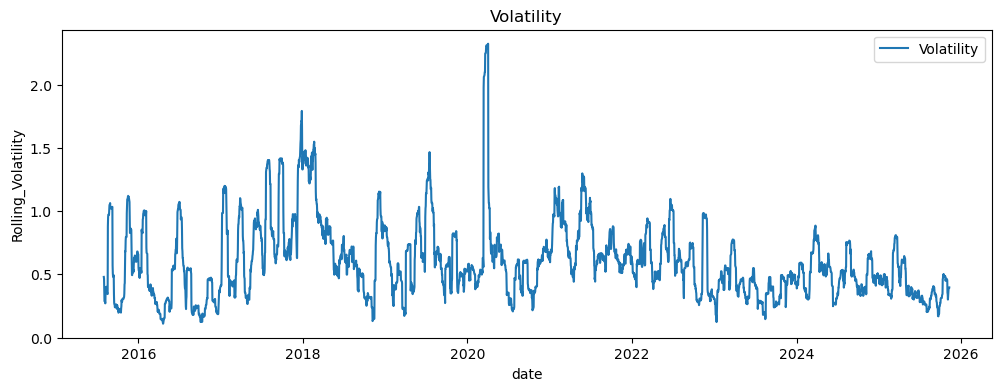

In [282]:
plt.figure(figsize=(12, 4)) 
plt.plot(df['Rolling_Volatility'], label="Volatility")
plt.title('Volatility') 
plt.xlabel("date")
plt.ylabel("Rolling_Volatility") 
plt.legend() 
plt.show()

In [283]:
df.head(3)

Price,Close,High,Low,Open,Volume,Log_Return,Rolling_Volatility,Future_Vol,Target_Volatility_Spike
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,
Date,,,,,,,,,
2015-08-01,281.601013,284.932007,278.112000,284.686005,18995000,-0.010769,0.479291,0.207307,0
2015-08-02,282.614014,283.032013,277.528992,280.449005,17722200,0.003591,0.464405,0.211427,0
2015-08-03,281.226990,285.471008,280.233002,282.806000,21474100,-0.004920,0.382510,0.211480,0


In [286]:
print(f"Размер датафрейма после базовой подготовки: {df.shape}")
print("\nРаспределение целевой переменной:")
print(df['Target_Volatility_Spike'].value_counts(normalize=True))

Размер датафрейма после базовой подготовки: (3754, 9)

Распределение целевой переменной:
Target_Volatility_Spike
0    0.899307
1    0.100693
Name: proportion, dtype: float64


In [289]:
# Лагированные логарифмические доходности
for i in [1, 2, 3, 5, 10, 14]: # Лаги за 1, 2, 3, 5, 10 дней
    df[f'Log_Return_lag_{i}'] = df['Log_Return'].shift(i)

In [291]:
# Дневной диапазон относительно цены закрытия
df['Daily_Range_Ratio'] = (df['High'].shift(1) - df['Low'].shift(1)) / df['Close'].shift(1)

In [293]:
# Разрывы (Gaps) - насколько цена открытия текущего дня отличается от закрытия предыдущего
df['Open_Prev_Close_Gap_Ratio'] = (df['Open'].shift(1) - df['Close'].shift(1)) / df['Close'].shift(1)

In [295]:
# Относительное положение цены закрытия в дневном диапазоне
# 0 = закрытие на минимуме, 1 = закрытие на максимуме
df['Close_Position_in_Range'] = (df['Close'].shift(1) - df['Low'].shift(1)) / (df['High'].shift(1) - df['Low'].shift(1))

In [297]:
# Обработка деления на ноль, если High == Low
df['Close_Position_in_Range'].fillna(0.5, inplace=True) # Можно установить 0.5 или 0, если диапазон равен 0


C:\Users\User\AppData\Local\Temp\ipykernel_10668\460677609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close_Position_in_Range'].fillna(0.5, inplace=True) # Можно установить 0.5 или 0, если диапазон равен 0


In [299]:
# Отношение цены закрытия к открытию
df['Close_Open_Ratio'] = df['Close'].shift(1) / df['Open'].shift(1)

In [301]:
print("Ценовые признаки созданы.")
df.dropna(inplace=True)
df.head()

Ценовые признаки созданы.


Price,Close,High,Low,Open,Volume,Log_Return,Rolling_Volatility,Future_Vol,Target_Volatility_Spike,Log_Return_lag_1,Log_Return_lag_2,Log_Return_lag_3,Log_Return_lag_5,Log_Return_lag_10,Log_Return_lag_14,Daily_Range_Ratio,Open_Prev_Close_Gap_Ratio,Close_Position_in_Range,Close_Open_Ratio
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,
2015-08-15,261.550995,266.666992,261.295990,265.528992,19321100,-0.015663,0.351457,1.926869,1,0.006041,-0.008657,-0.014942,-0.002315,-0.011765,-0.010769,0.022538,-0.005827,0.701735,1.005861
2015-08-16,258.506989,262.440002,257.040985,261.865997,29717000,-0.011707,0.353947,2.018756,1,-0.015663,0.006041,-0.008657,0.022123,-0.011794,0.003591,0.020535,0.015209,0.047478,0.985019
2015-08-17,257.976013,260.505005,257.117004,258.489990,21617900,-0.002056,0.345566,2.018680,1,-0.011707,-0.015663,0.006041,-0.014942,0.003612,-0.004920,0.020885,0.012994,0.271532,0.987173
2015-08-18,211.078995,257.993011,211.078995,257.925995,42147200,-0.200634,0.343727,2.013302,1,-0.002056,-0.011707,-0.015663,-0.008657,-0.068797,0.014092,0.013133,0.001992,0.253544,0.998012
2015-08-19,226.684006,237.408997,222.766006,225.671005,60869200,0.071325,0.878041,0.715238,0,-0.200634,-0.002056,-0.011707,0.006041,0.015534,-0.011765,0.222258,0.221941,0.000000,0.818370


In [303]:
print("\n--- Шаг 2: Создание признаков, связанных с объёмом ---")


--- Шаг 2: Создание признаков, связанных с объёмом ---


In [305]:
# Лагированные объёмы
for i in [1, 2, 3, 5, 10]:
    df[f'Volume_lag_{i}'] = df['Volume'].shift(i)

In [307]:
# Показывает, насколько текущий объем выше/ниже среднего
volume_ma_window = 20
# Volume_MA
df['Volume_MA'] = df['Volume'].shift(1).rolling(volume_ma_window).mean()

In [309]:
df.columns = df.columns.droplevel(1)

In [311]:
# Отношение текущего объёма к скользящему среднему объёма
df['Volume_to_MA_Ratio'] = df['Volume'].shift(1) / df['Volume_MA'].shift(1)

In [313]:
# Изменение объёма относительно предыдущего дня
df['Volume_Daily_Change_Ratio'] = (df['Volume'] - df['Volume'].shift(1)) / df['Volume'].shift(1)

In [315]:
print("\n--- Шаг 3: Создание признаков, связанных с волатильностью ---")


--- Шаг 3: Создание признаков, связанных с волатильностью ---


In [317]:
# Лагированная скользящая волатильность
for i in [1, 2, 3, 5, 10]:
    df[f'Rolling_Volatility_lag_{i}'] = df['Rolling_Volatility'].shift(i)

In [319]:
# Изменение скользящей волатильности относительно предыдущего дня
# Rolling_Volatility_Daily_Change_Ratio — на lagged vol
df['Rolling_Volatility_Daily_Change_Ratio'] = (
    df['Rolling_Volatility'] - df['Rolling_Volatility'].shift(1)
) / df['Rolling_Volatility'].shift(1)

In [321]:
# Отношение краткосрочной волатильности к долгосрочной
short_vol_window = 10
long_vol_window = 50
# Short/Long Vol
df['Short_Term_Volatility'] = df['Log_Return'].shift(1).rolling(short_vol_window).std() * np.sqrt(365)
df['Long_Term_Volatility'] = df['Log_Return'].shift(1).rolling(long_vol_window).std() * np.sqrt(365)
df['Vol_Ratio_Short_Long'] = df['Short_Term_Volatility'] / df['Long_Term_Volatility']

In [323]:
print("\nШаг 4: Создание технических индикаторов ")


Шаг 4: Создание технических индикаторов 


In [325]:
# Relative Strength Index (RSI)
rsi_indicator = ta.momentum.RSIIndicator(df['Close'].shift(1), window=14)
df['RSI'] = rsi_indicator.rsi()

In [327]:
indic = ta.wrapper.StochasticOscillator

In [329]:
# Moving Average Convergence Divergence (MACD)
macd_indicator = ta.trend.MACD(close=df[price_col].shift(1), window_fast=12, window_slow=26, window_sign=9)
df['MACD'] = macd_indicator.macd()
df['MACD_Signal'] = macd_indicator.macd_signal()
df['MACD_Diff'] = macd_indicator.macd_diff() # Отклонение MACD от сигнальной линии

In [331]:
# Bollinger Bands (BB)
bb_band = ta.volatility.BollingerBands(close=df[price_col].shift(1), window=20, window_dev=2)
df['BB_Upper'] = bb_band.bollinger_hband()
df['BB_Lower'] = bb_band.bollinger_lband()
df['BB_Width'] = bb_band.bollinger_wband()
df['BB_Percent'] = bb_band.bollinger_pband()

In [333]:
# KeltnerChannel
KeltnerChannel = ta.volatility.KeltnerChannel(high=df['High'].shift(1), low=df['Low'].shift(1), close=df['Close'].shift(1), original_version=True, window=20, window_atr=10, multiplier=2)
df['KC_high'] = KeltnerChannel.keltner_channel_hband()
df['KC_low'] = KeltnerChannel.keltner_channel_lband()
df['KC_mid'] = KeltnerChannel.keltner_channel_mband()
df['KC_Percent'] = KeltnerChannel.keltner_channel_pband()

In [335]:
#UlcerIndex = ta.volatility.UlcerIndex(close=df['Close'], window=14, fillna=False)
#df['UI'] = UlcerIndex.ulcer_index()

пояснить atr

In [338]:
# Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'].shift(1), low=df['Low'].shift(1), close=df['Close'].shift(1), window=14).average_true_range()

In [340]:
df.dropna(inplace=True)

In [342]:
print("\n--- Шаг 5: Создание временных признаков ---")


--- Шаг 5: Создание временных признаков ---


In [344]:
'''df['Day_of_Week'] = df.index.dayofweek # 0=Понедельник, 6=Воскресенье
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year'''

"df['Day_of_Week'] = df.index.dayofweek # 0=Понедельник, 6=Воскресенье\ndf['Month'] = df.index.month\ndf['Quarter'] = df.index.quarter\ndf['Year'] = df.index.year"

In [346]:
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df['DayOfMonth_sin'] = np.sin(2 * np.pi * df.index.day / 31)

df['DayOfWeek_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
df['DayOfMonth_cos'] = np.cos(2 * np.pi * df.index.day / 31)

In [348]:
feature_columns = [col for col in df.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume',
                                                            'Log_Return', 'Rolling_Volatility', 'Volume_MA',
                                                            'Short_Term_Volatility', 'Long_Term_Volatility',
                                                            'Target_Volatility_Spike']] # Исключаем целевую

In [350]:
df.to_csv('df_volatility.csv', index=True)

In [352]:
df.head()

Price,Close,High,Low,Open,Volume,Log_Return,Rolling_Volatility,Future_Vol,Target_Volatility_Spike,Log_Return_lag_1,...,BB_Percent,KC_high,KC_low,KC_mid,KC_Percent,ATR,DayOfWeek_sin,DayOfMonth_sin,DayOfWeek_cos,DayOfMonth_cos
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-04,238.259003,238.968002,237.940002,238.531006,12999000,-0.001975,0.215965,0.261876,0,0.006038,...,0.899884,238.322569,229.108565,233.715567,1.044218,4.857551,-0.781831,0.724793,0.623490,0.688967
2015-10-05,240.382996,240.382996,237.035004,238.147003,23335900,0.008875,0.196121,0.257367,0,-0.001975,...,0.826996,238.552053,229.683148,234.117601,0.966958,4.584011,0.000000,0.848644,1.000000,0.528964
2015-10-06,246.063004,246.934998,240.136002,240.363998,27535100,0.023354,0.198389,0.253517,0,0.008875,...,0.918677,237.226335,230.958632,234.092484,1.503639,4.495724,0.781831,0.937752,0.623490,0.347305
2015-10-07,242.968994,246.681000,242.585007,246.169998,22999200,-0.012654,0.216683,0.165395,0,0.023354,...,1.136460,238.132735,231.566432,234.849584,2.207722,4.660244,0.974928,0.988468,-0.222521,0.151428
2015-10-08,242.304001,244.251007,242.179001,243.074997,18515300,-0.002741,0.223977,0.126219,0,-0.012654,...,0.905709,238.989818,232.149817,235.569817,1.581751,4.619940,0.433884,0.998717,-0.900969,-0.050649


In [222]:
# Let's make simple data analysis

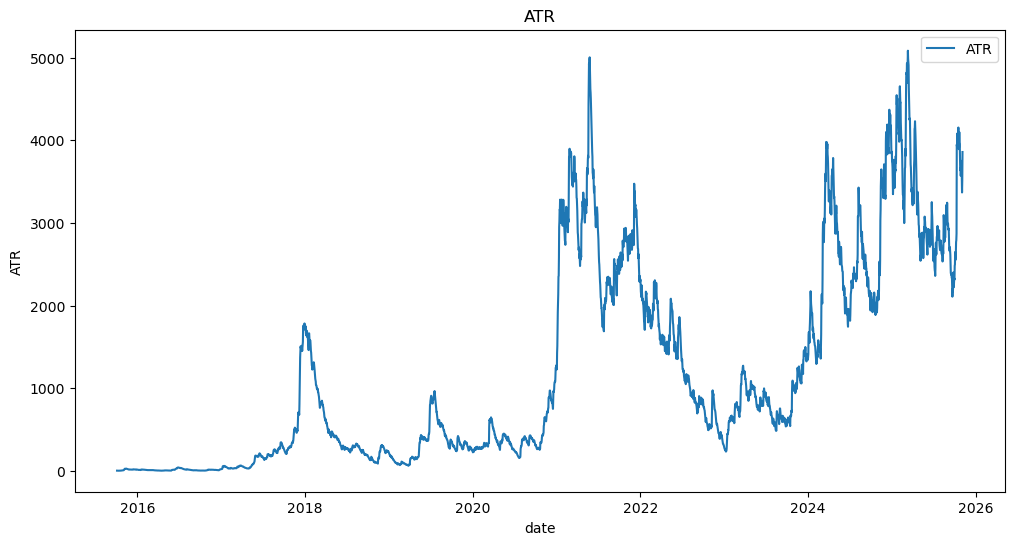

In [227]:
plt.figure(figsize=(12, 6)) 
plt.plot(df['ATR'], label="ATR")
plt.title('ATR') 
plt.xlabel("date")
plt.ylabel("ATR") 
plt.legend() 
plt.show()

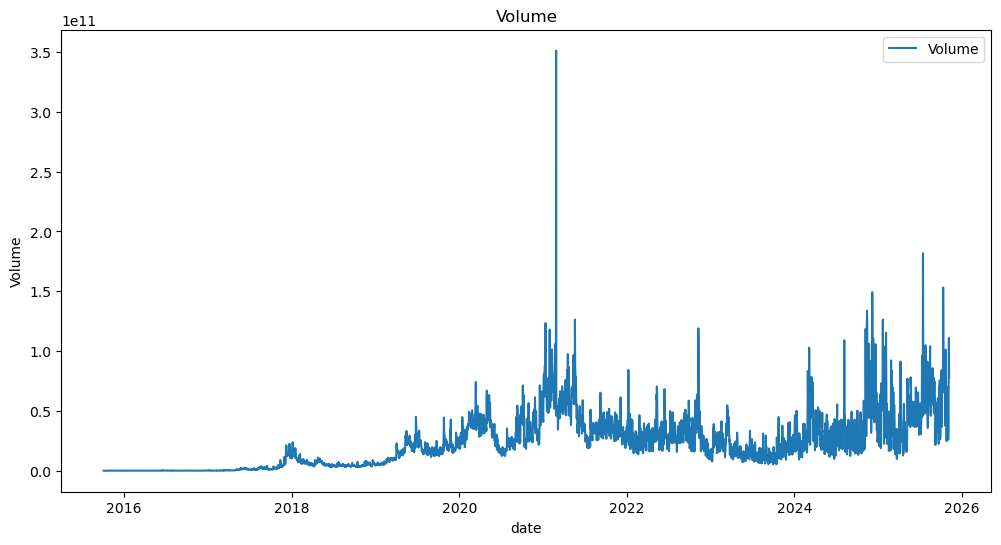

In [241]:
plt.figure(figsize=(12, 6)) 
plt.plot(df['Volume'], label="Volume")
plt.title('Volume') 
plt.xlabel("date")
plt.ylabel("Volume") 
plt.legend() 
plt.show()

In [243]:
df.head(2)

Price,Close,High,Low,Open,Volume,Log_Return,Rolling_Volatility,Future_Vol,Target_Volatility_Spike,Log_Return_lag_1,...,BB_Lower,BB_Width,BB_Percent,KC_high,KC_low,KC_mid,KC_Percent,ATR,DayOfWeek_sin,DayOfMonth_sin
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-04,238.259003,238.968002,237.940002,238.531006,12999000,-0.001975,0.215965,0.261876,0,0.006038,...,226.481958,5.834302,0.899884,238.322569,229.108565,233.715567,1.044218,4.857551,-0.781831,0.724793
2015-10-05,240.382996,240.382996,237.035004,238.147003,23335900,0.008875,0.196121,0.257367,0,-0.001975,...,226.648153,6.008436,0.826996,238.552053,229.683148,234.117601,0.966958,4.584011,0.000000,0.848644
